<span style="font-size:200%; text-align:left;"><b>Lab setup of long SRC in a Michelson</b></span>
<br/>
Code : Mostly D.Toyra but I, V Adya chipped in


# Importing packages

In [1]:
import pykat
import pykat.ifo as ifo
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
from pykat.optics import ABCD as a

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

import pickle
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset']=False


from scipy.optimize import minimize
from pykat.optics.gaussian_beams import BeamParam

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



# Designing the waist size in the crystal  


## Controller

In [2]:
RoC = [0.1,0.25,0.5,0.75,1,1.333,1.5,2,3,4,5,6.667,10]   # RoCs available off the shelf


RoC_EX = 5
RoC_EY = 5


w_crys = 30e-6

# Constraints
w_bs = 3.4e-3
w_etm = 4.8e-3
w_srm = 4.8e-3

## The model

In [3]:
base = pykat.finesse.kat()
base.verbose = True
base.load("LongSRC_design_03Oct.kat")

base.removeBlock('Photodiodes')

base.EX.Rc = RoC_EX
base.EY.Rc = RoC_EY


## Run 0
Setting the radii of curvature of the End Mirrors and the SRM

In [4]:
kat = base.deepcopy()
kat.cTSRM.remove()
kat.parse("""
bp w_ex x w nEMx
bp w_ey x w nEMy
bp w_bs x w nBS4
bp w_srm x w nSRM1

cp cSRMX x m
cp cSRMY x m
cp cSRMX y m
cp cSRMY y m 

noxaxis
yaxis abs
trace 2
""")

kat.SRM.Rc = 5
out = kat.run()
print(out.stdout)
print()
print('      w      max_w')
print('EX:  {:.4f}   {} '.format(out['w_ex']*1e3, w_etm*1e3 ))
print('EY:  {:.4f}   {} '.format(out['w_ey']*1e3, w_etm*1e3 ))
print('BS:  {:.4f}   {} '.format(out['w_bs']*1e3, w_bs*1e3 ))
print('SRM: {:.4f}   {} '.format(out['w_srm']*1e3, w_srm*1e3 ))

print()

print('EX:  diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_ex']-w_etm)*1e3, (out['w_ex']-w_etm)/np.abs(w_etm) ) )
print('EY:  diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_ey']-w_etm)*1e3, (out['w_ey']-w_etm)/np.abs(w_etm) ) )
print('BS:  diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_bs']-w_bs)*1e3, (out['w_bs']-w_bs)/np.abs(w_bs) ) )
print('SRM: diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_srm']-w_srm)*1e3, (out['w_srm']-w_srm)/np.abs(w_srm) ) )
print()

# Checking stability
# --------------------
mX_x = np.abs(out['cSRMX_x_m'])
mY_x = np.abs(out['cSRMY_x_m'])
mX_y = np.abs(out['cSRMX_x_m'])
mY_y = np.abs(out['cSRMY_x_m'])

if (not (mX_x > -1 and mX_x < 1) or not (mX_y > -1 and mX_y < 1) or 
    not (mY_x > -1 and mY_x < 1) or not (mY_y > -1 and mY_y < 1)):
    print('Cavity is unstable!!!!! :(')
    print('Stability parameters: {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y))
else:
    print('Cavity is stable! :) ')
    print('Stability parameters: {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y))
# --------------------
  
    


--------------------------------------------------------------
Running kat - Started at 2019-10-09 15:30:24.136154

Finished in 0.0286689 seconds

------------------------------------------------------------------------
                     FINESSE 2.2                (build 2.2-31-ge1141681)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        06.03.2019         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmppojj_nhy.kat,
  ~~ \)-'   '        Output file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmppojj_nhy.out,
     / |             Gnuplot file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmppojj_nhy.gnu 
    '  '                                        Wed Oct  9 15:30:24 2019
------------------------------------------------------------------------
 'noxaxis' has been set, ignoring all other xaxis commands
 --- cavity tracing
 cavity cSRMX:
  

100% | ETA:  0:00:00 | Calculating                                             

## Run 1 : Checking the IFO Tuning

### Y Arm

--------------------------------------------------------------
Running kat - Started at 2019-10-09 15:30:24.190658

Finished in 0.0243578 seconds


100% | ETA:  0:00:00 | Calculating                                             

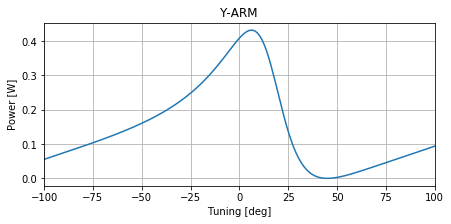

In [5]:
kat = base.deepcopy()
kat.parse("""
xaxis EY phi lin -100 100 200
yaxis abs
hd PY 0 nOut1 nOut2
""")
out = kat.run()
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(111)
ax.plot(out.x, out['PY'])
ax.set_xlim(out.x.min(),out.x.max())
ax.grid()
ax.set_title('Y-ARM')
ax.set_xlabel('Tuning [deg]')
ax.set_ylabel('Power [W]')
plt.show(fig)

### X Arm tuning 

--------------------------------------------------------------
Running kat - Started at 2019-10-09 15:30:24.349536

Finished in 0.025929 seconds


100% | ETA:  0:00:00 | Calculating                                             

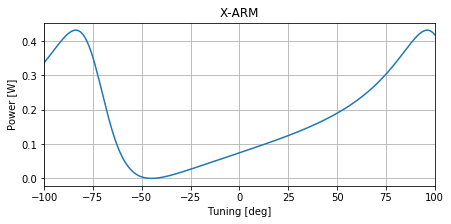

In [6]:
kat = base.deepcopy()
kat.parse("""
xaxis EX phi lin -100 100 200
yaxis abs
hd P_X 0 nOut1 nOut2
""")
out = kat.run()

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(111)
ax.plot(out.x, out['P_X'])
ax.set_xlim(out.x.min(),out.x.max())
ax.grid()
ax.set_title('X-ARM')
ax.set_xlabel('Tuning [deg]')
ax.set_ylabel('Power [W]')
plt.show(fig)

### HOM content test in the SRC

Parsing `tem Laser 1 0 1.0 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem Laser 2 0 1.0 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem Laser 3 0 1.0 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem Laser 4 0 1.0 0.0` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2019-10-09 15:30:24.506744


100% | ETA:  0:00:00 | Calculating                                             


Finished in 0.358695 seconds


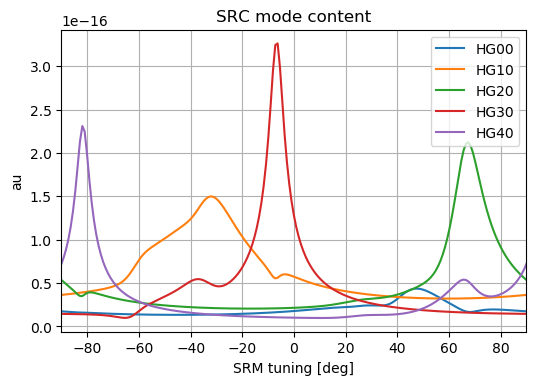

In [7]:
kat = base.deepcopy()
kat.maxtem = 4
kat.parse("""
tem Laser  1 0 1.0 0.0
tem Laser  2 0 1.0 0.0
tem Laser  3 0 1.0 0.0
tem Laser  4 0 1.0 0.0

xaxis SRM phi lin -90 90 200
yaxis abs

pd P_HOM nSRM1*

ad C 0 0 0 nSRM1*
ad C10 1 0 0 nSRM1*
ad C20 2 0 0 nSRM1*
ad C30 3 0 0 nSRM1*
ad C40 4 0 0 nSRM1*


""")
out = kat.run()

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(out.x, out['C'],label = 'HG00')
ax.plot(out.x, out['C10'],label = 'HG10')
ax.plot(out.x, out['C20'],label = 'HG20')
ax.plot(out.x, out['C30'],label = 'HG30')
ax.plot(out.x, out['C40'],label = 'HG40')

ax.set_xlim(out.x.min(),out.x.max())
ax.grid()
ax.legend()
ax.set_title('SRC mode content')
ax.set_xlabel('SRM tuning [deg]')
ax.set_ylabel('au')
plt.show(fig)

## Splitting frequency test

Note : Maxtem is turned off because we have not yet optimised the RoCs for TSRM

--------------------------------------------------------------
Running kat - Started at 2019-10-09 15:33:40.748885

Finished in 0.0513082 seconds


100% | ETA:  0:00:00 | Calculating                                             

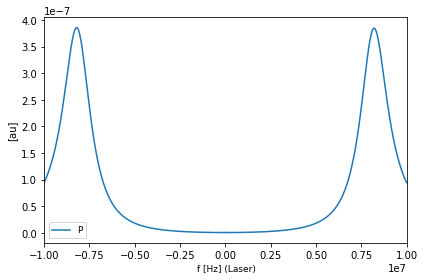


------------------------------------------------------------------------
                     FINESSE 2.2                (build 2.2-31-ge1141681)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        06.03.2019         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpr3or2_z5.kat,
  ~~ \)-'   '        Output file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpr3or2_z5.out,
     / |             Gnuplot file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpr3or2_z5.gnu 
    '  '                                        Wed Oct  9 15:33:40 2019
------------------------------------------------------------------------
 
 computation time:  0.0376119s



In [17]:
kat = base.deepcopy()
kat.maxtem = 'off'
kat.parse("""
pd P nSRM1
xaxis Laser f lin -10M 10M 1000
#xaxis SRM phi lin 40 50 200

yaxis abs
# trace 2
#maxtem off
""")
kat.eom1.midx = 0

dMICH = 0.002
kat.EX.phi = kat.EX.phi.value + dMICH
kat.EY.phi = kat.EY.phi.value - dMICH

out = kat.run()
out.plot()

print(out.stdout)

# Testing swept sine technique of measurement

## EOM frequency variation

In [9]:
kat = base.deepcopy()
kat.maxtem = 'off'


lschn = 5e-3
kat.LX.L = kat.LX.L - lschn
kat.LY.L = kat.LY.L + lschn

kat.eom1.midx = 1.2
kat.eom1.f = 1e6

kat.parse("""
pd1 eom_test 0 0 nOut 
xaxis eom1 f lin -10M 10M 1000
put eom_test f $x1
yaxis abs
""")

out = kat.run()


print(kat.LX.L, "m")
print(kat.LY.L, "m")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(out.x, out['eom_test']*1e3)
ax.grid()
ax.set_ylabel('demodulated sideband output [mW]')
ax.set_xlabel('Frequency [Hz]')
plt.show(fig)


put command component `put eom_test f $x1` does not have a
parameter `f`


Parsing `put eom_test f $x1` into pykat object not implemented
yet, added as extra line.

--------------------------------------------------------------
Running kat - Started at 2019-10-09 15:30:25.239586

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
 
Error:  photodetector eom_test not connected to
interferometer.
--------------------------------------------------------------


Finished in 0.0176399 seconds


SystemExit: 1

/miniconda3/envs/py37env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3299: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Changing Schnupp asymmetry

In [ ]:
fig = plt.figure(figsize=(7,9), dpi=100)
ax1 = fig.add_subplot(211)

kat = base.deepcopy()
# Adding simulation instructions and detectors.
kat.parse("""
pd1 eom_test 0 0 nOut 
xaxis eom1 f lin -10M 10M 1000
put eom_test f $x1
yaxis abs
""")
kat.maxtem = 'off'
kat.eom1.midx = 1.2
arr = np.linspace(1e-3,50e-3,5)

for k,a in enumerate(arr):
    lschn = a
    kat.LX.L = kat.LX.L - lschn
    kat.LY.L = kat.LY.L + lschn
    out = kat.run(cmd_args=["-cr=on"])
    
    ax1.plot(out.x,(out['eom_test']),label="%g" %a)
       
plt.ylabel("Demodulated output [W]")
plt.xlabel("Frequency [Hz]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.grid
#plt.savefig("InputPowers_Sensitivity.eps")
plt.show()
    


## Changing SRM T

In [ ]:
fig = plt.figure(figsize=(7,9), dpi=100)
ax1 = fig.add_subplot(211)

kat = base.deepcopy()
# Adding simulation instructions and detectors.
kat.parse("""
pd1 eom_test 0 0 nOut 
xaxis eom1 f lin -15M 15M 1000
put eom_test f $x1
yaxis abs
""")
kat.maxtem = 'off'
kat.eom1.midx = 1.2

lschn = 5e-3
kat.LX.L = kat.LX.L - lschn
kat.LY.L = kat.LY.L + lschn

arr = np.linspace(0.1,0.3,5)

for k,a in enumerate(arr):
    kat.SRM.T = a
    kat.SRM.R = 1-a
    out = kat.run(cmd_args=["-cr=on"])
    ax1.plot(out.x,(out['eom_test']),label="%g" %a)
       
plt.ylabel("Demodulated output [W]")
plt.xlabel("Frequency [Hz]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.grid
#plt.savefig("InputPowers_Sensitivity.eps")
plt.show()
    


## Changing TSRM T

In [ ]:
fig = plt.figure(figsize=(7,9), dpi=100)
ax1 = fig.add_subplot(211)

kat = base.deepcopy()
# Adding simulation instructions and detectors.
kat.parse("""
pd1 eom_test 0 0 nOut 
xaxis eom1 f lin -10M 10M 1000
put eom_test f $x1
yaxis abs
""")
kat.maxtem = 'off'
kat.eom1.midx = 1.2

lschn = 5e-3
kat.LX.L = kat.LX.L - lschn
kat.LY.L = kat.LY.L + lschn

arr = np.linspace(0.1,0.3,5)

for k,a in enumerate(arr):
    kat.TSRM.T = a
    kat.TSRM.R = 1-a
    out = kat.run(cmd_args=["-cr=on"])
    ax1.plot(out.x,(out['eom_test']),label="%g" %a)
       
plt.ylabel("Demodulated output [W]")
plt.xlabel("Frequency [Hz]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.grid
#plt.savefig("InputPowers_Sensitivity.eps")
plt.show()
    


## GW signal from input vs GW signal from arms

In [ ]:
kat = base.deepcopy()
kat.parse("""
pd1 Readout $fs max nOut 

fsig darm LX phase 1.0 0.0 
fsig darm LY phase 1.0 180.0 

xaxis darm f log 1M 15M 1000
yaxis abs:deg

""")
kat.maxtem = 'off'

out = kat.run()

fig = plt.figure(figsize=(7,10), dpi=100)
ax = fig.add_subplot(111)

ax.loglog(out.x, out['Readout'], 'y--', label='Michelson TF')
ax.legend()
ax.set_ylabel("Amplitude [$\sqrt{\mathrm{W}}$]",fontsize=14)
ax.grid()

ax.set_xlabel('Frequency [Hz]',fontsize=14)
plt.show(fig)

In [ ]:
kat = base.deepcopy()
kat.parse(""" 
# Amplitude detectors
ad Ap $fs nOut
ad An $mfs nOut

xaxis eom1 f lin -10M 10M 1000

""")
kat.maxtem = 'off'

out = kat.run()
Ap_tsrm = np.abs(out['Ap'])
An_tsrm = np.abs(out['An'])

fig = plt.figure(figsize=(7,10), dpi=100)
ax = fig.add_subplot(211)

ax.plot(out.x, Ap_tsrm, 'y--', label='Michelson + TSRM, upper sideband')
ax.plot(out.x, An_tsrm, 'm-.', label='Michelson + TSRM, lower sideband')
ax.legend()
ax.set_ylabel("Amplitude [$\sqrt{\mathrm{W}}$]",fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()

ax.set_xlabel('Frequency [Hz]',fontsize=14)
plt.show(fig)

# RoCs for TSR1, TSR2 and TSRM
## Getting the beam parameters everywhere

In [10]:
kat = base.deepcopy()
kat.cTSRM.remove()

kat.parse("""

bp qex x q nEMx
bp qbsx x q nBS4
bp qsrm x q nSRM1
bp qtsr1 x q nTSR1a
bp qtsr2 x q nTSR2a
bp qcr1 x q nCRYS1a
bp q_cr1b x q nCRYS1b
bp qcr2 x q nCRYS2b
bp qtsrm x q nTSRM1


cp cSRMX x m
cp cSRMY x m
cp cSRMX y m
cp cSRMY y m

noxaxis
yaxis abs:deg
""")

                
out = kat.run()


qex = out['qex']

qbsx = out['qbsx']
qsrm = out['qsrm']

qtsr1 = out['qtsr1']
qtsr2 = out['qtsr2']


qcr1 = out['qcr1']
qcr2 = out['qcr2']
qtsrm = out['qtsrm']



--------------------------------------------------------------
Running kat - Started at 2019-10-09 15:30:48.652645

Finished in 0.018784 seconds


100% | ETA:  0:00:00 | Calculating                                             

## Choosing of radii of curvature

In [ ]:
RoC = [0.1,0.25,0.5,0.75,1,1.333,1.5,2,3,4,5,6.667,10]   # RoCs available off the shelf

q0 = BeamParam(q=qsrm1)





if (not (mX_x > -1 and mX_x < 1) or not (mX_y > -1 and mX_y < 1) or 
    not (mY_x > -1 and mY_x < 1) or not (mY_y > -1 and mY_y < 1)):
    

In [ ]:
def q2w(q0,z,n=1):
    w = np.zeros(len(z))
    for k,a in enumerate(z):
        w[k] = BeamParam(q=q0+a, nr=n).w
    return w



###############################################
# Lengths and parameters
###############################################


# End mirror
w_ex = BeamParam(q=qex).w

# End mirror to BS
L_ex_bs = kat.LX.L.value
z_ex_bs = np.linspace(0,L_ex_bs,50)
w_ex_bs = q2w(qex, z_ex_bs)

# BS
w_bs = BeamParam(q=qbsx).w

# BS to SRM
L_bs_srm = kat.SRC1.L.value
z_bs_srm = np.linspace(0,L_bs_srm,50)
w_bs_srm = q2w(qbsx,z_bs_srm)
z_bs_srm += L_ex_bs

# SRM
w_srm = BeamParam(q=qsrm).w

# SRM substrate
L_srm_sub = kat.thsrm1.L.value

# SRM AR
w_srmar = BeamParam(q=qsrmarx).w

# SRM AR to Crystal
L_srm_crys = kat.SRCc2.L.value
z_srm_crys = np.linspace(0,L_srm_crys,50)
w_srm_crys = q2w(qsrmarx, z_srm_crys)
z_srm_crys += L_ex_bs+L_bs_srm+L_srm_sub

# Crystal, surface 1
w_crys = BeamParam(q=qcr1).w

# Inside the Crystal
L_crys = kat.sCRYS.L.value
z_crys_sub = np.linspace(0,L_crys,50)
w_crys_sub = q2w(qcr1*kat.sCRYS.n.value, z_crys_sub, n=kat.sCRYS.n.value)
z_crys_sub += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys


# Crystal, surface 2
w_crys2 = BeamParam(q=qcr2).w

# Crystal to TSRM
L_crys_tsrm = kat.SRC2.L.value
z_crys_tsrm = np.linspace(0,L_crys_tsrm,50)
w_crys_tsrm = q2w(qcr2,z_crys_tsrm)
z_crys_tsrm += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys

# TSRM
w_tsrm = BeamParam(q=qtsrm).w


###############################################
# Plotting
###############################################

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# End mirror
ax.plot(0,w_ex*1e3,'b*')
ax.plot(0,-w_ex*1e3,'b*')

# End mirror to BS
ax.plot(z_ex_bs, w_ex_bs*1e3,'-b')
ax.plot(z_ex_bs, -w_ex_bs*1e3,'-b')

# BS
ax.plot(L_ex_bs, w_bs*1e3,'b*')
ax.plot(L_ex_bs, -w_bs*1e3,'b*')

# BS to SRM
ax.plot(z_bs_srm, w_bs_srm*1e3,'-b')
ax.plot(z_bs_srm, -w_bs_srm*1e3,'-b')

# SRM
ax.plot(L_ex_bs+L_bs_srm,w_srm*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm,-w_srm*1e3,'b*')

# SRMAR
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,w_srmar*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,-w_srmar*1e3,'b*')

# SRMAR to Crystal
ax.plot(z_srm_crys, w_srm_crys*1e3,'-b')
ax.plot(z_srm_crys, -w_srm_crys*1e3,'-b')

# Crystal surface 1
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, w_crys*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, -w_crys*1e3,'b*')

# Inside Crystal
ax.plot(z_crys_sub, w_crys_sub*1e3,'-b')
ax.plot(z_crys_sub, -w_crys_sub*1e3,'-b')

# Crystal surface 2
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, w_crys2*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, -w_crys2*1e3,'b*')

# Crystal to TSRM
ax.plot(z_crys_tsrm, w_crys_tsrm*1e3,'-b')
ax.plot(z_crys_tsrm, -w_crys_tsrm*1e3,'-b')

# TSRM
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, w_tsrm*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, -w_tsrm*1e3,'b*')

ax.set_ylabel('w [m]')
ax.set_xlabel('z [m]')

ax.grid()
ax.set_ylabel('Beam radius [mm]')
ax.set_title('EX-BS-SRM-TSRM cavities')
#plt.savefig('Beam_Evolution.png')
plt.show(fig)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# Crystal surface 1
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, w_crys*1e6,'b*')
#ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, -w_crys*1e6,'b*')

# Inside Crystal
ax.plot(z_crys_sub, w_crys_sub*1e6,'-b')
#ax.plot(z_crys_sub, -w_crys_sub*1e6,'-b')

# Crystal surface 2
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, w_crys2*1e6,'b*')
#ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, -w_crys2*1e6,'b*')
ax.grid()
ax.set_ylabel('Beam radius [um]')
ax.set_title('Inside crystal')
#plt.savefig('Beam_Evolution_zoomed.png')
plt.show(fig)

# Playground
## PyKat ABCD matrix usage

In [13]:
# q0 = pykat.optics.gaussian_beams.BeamParam(w0=315.781231594237e-6, z=460.76086956521e-3)

q0 = BeamParam(q=qbsx) # Here we import the beam parameter from nBS4 which is 
                     # the node of the BS facing the HR surface of SRM

# Define the function here and the parameters to vary are 
# RoC of the AR surface of SRM (roc in the functions below) and the distance between
# crystal and the AR surface of SRM (L in the functions below)

# Here we have used the pykat ABCD matrices which account for refractive index in beam parameter
# Unlike the wikipedia ABCD matrices which have the beam parameter included in the matrix element
# so tl:dr be careful when comparing things
# The function rocL calculates the beam parameters and we have this here
# to make sure we get a waist at the centre of the crystal

def rocL(roc, L):
    S0 = a.space(1,kat.SRC1.L.value)
    S1 = a.mirror_trans(1, kat.thsrm1.n.value, np.inf)
    S2 = a.space(kat.thsrm1.n.value, kat.thsrm1.L.value)
    S3 = a.mirror_trans(kat.thsrm1.n.value, 1, roc)
    S4 = a.space(1, L)
    S5 = a.mirror_trans(1, kat.sCRYS.n.value, np.inf) 
    S6 = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value/2.0)

    Ssum = S6 * S5 * S4 * S3 * S2 * S1 * S0

    return a.apply(Ssum, q0, 1, 1.8)

# Here we define a function to vary the L and roc
def fun2(L, roc):
    if L <=0:   # Adding this here to make sure that the minimisation routine does not spit out negative values of L for me
        return 1000
    return np.abs(rocL(roc, L).z)
    

diopt = np.linspace(0.1, 100, 20) #Dioptres is used because - just easier to do. We have gone from 1 cm RoC to 10 m RoC

for k,d in enumerate(diopt):
    
    sol = minimize(fun2, 0.07, args=(1/d), method='Nelder-Mead', tol=1e-6) # Minimisation routine to find the best roc and L 
    
    L = sol.x[0]
    q = rocL(1.0/d, L)
    z = q.z
    w0 = q.w0
    
    print('RoC = {:10.6f} m ---> L = {:.2e} m, where z = {:9.2e} m, w0 = {:.3f} mm'.format(1.0/d, L, z, w0*1e3))

AttributeError: 'kat_10' object has no attribute 'SRC1'

## SRM transmission vs. cavity length for a given splitting frequency

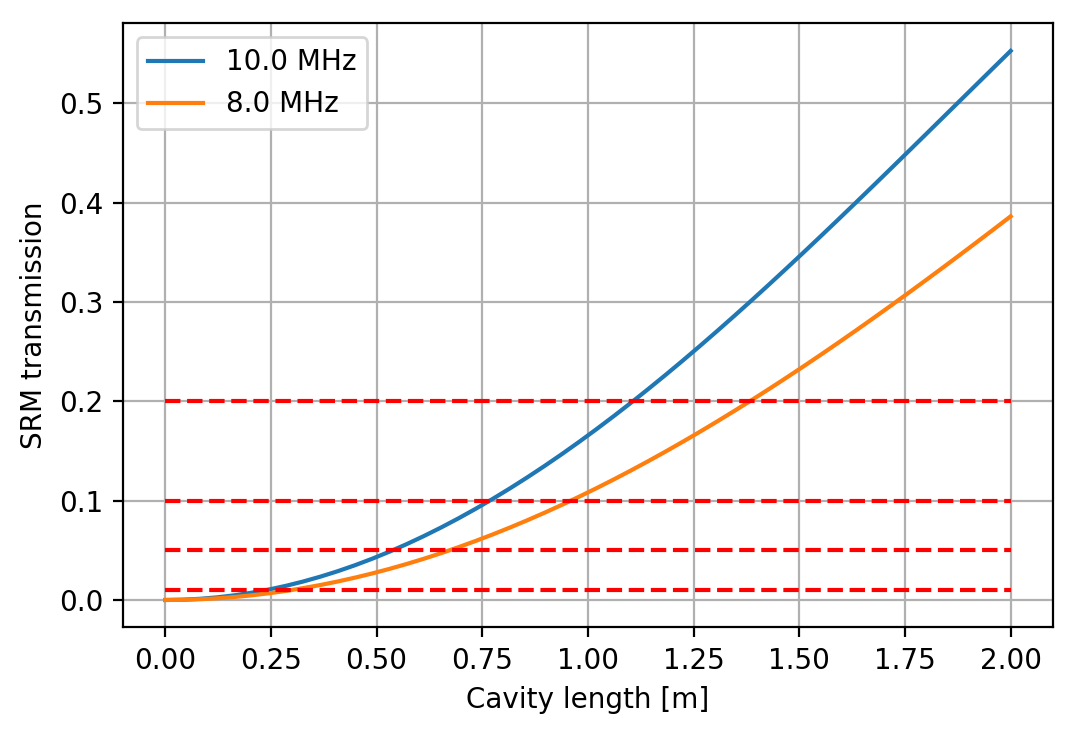

In [12]:
L = np.linspace(0,2,50)
c = 299792458.0
f_sp = 10e6
T = np.sin(4.0*np.pi*f_sp*L/c)**2

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

ax.plot(L,T, label='{} MHz'.format(f_sp*1e-6))
f_sp = 8e6
T = np.sin(4.0*np.pi*f_sp*L/c)**2


ax.plot(L,T, label='{} MHz'.format(f_sp*1e-6))

ax.plot([0,L.max()], [0.01,0.01],'r--')
ax.plot([0,L.max()], [0.05,0.05],'r--')
ax.plot([0,L.max()], [0.1,0.1],'r--')
ax.plot([0,L.max()], [0.2,0.2],'r--')

ax.set_xlabel('Cavity length [m]')
ax.set_ylabel('SRM transmission')
ax.grid()
ax.legend()
plt.show(fig)

In [19]:
T = np.sin(4.0*np.pi*f_sp*L/c)**2


In [20]:
L_SRC = c*np.arcsin(np.sqrt(0.2))/(4.0*np.pi*8e6)

# Spot size on end mirrors, from clipping loss

## For most optics

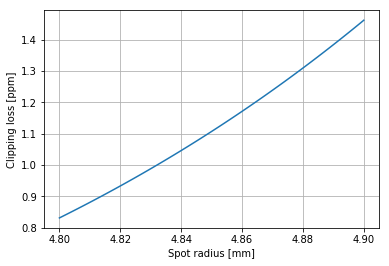

In [14]:
R = 0.0254/2.0 # Radius of the optic i.e. size
w = np.linspace(4.8e-3,4.9e-3,100)
L = np.exp(-2*R**2/w**2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(w*1e3, L*1e6)
ax.grid()
ax.set_ylabel('Clipping loss [ppm]')
ax.set_xlabel('Spot radius [mm]')
plt.show(fig)

## For the beam splitter

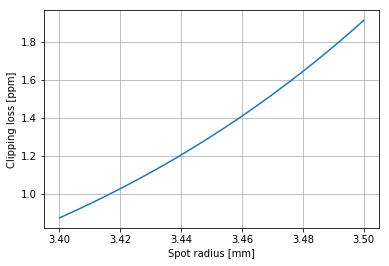

In [15]:
R = 0.0254/2.0 # Radius of the beam splitter
# Compensating for 45 degree angle of incidence
R /= np.sqrt(2)
w = np.linspace(3.4e-3,3.5e-3,100)
L = np.exp(-2*R**2/w**2)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(w*1e3, L*1e6)
ax.grid()
ax.set_ylabel('Clipping loss [ppm]')
ax.set_xlabel('Spot radius [mm]')
plt.show(fig)

## Angle of incidence for the folded cavity

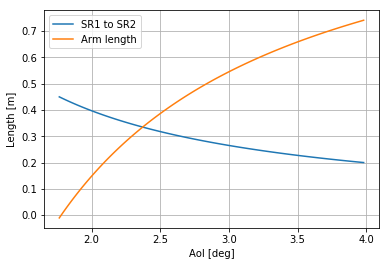

In [21]:
# Safety margin between SR2 and the optical axis between SR2 and SRM.
d = 0.015
# Radius of SR1
a = 0.0127
# Safety margin between SRM and SR1 + safety margin between SR2 and X-arm. Quickly estimated values. 
b = 0.01 + 0.035
# Distance between telescope mirrors
L = np.linspace(0.2,0.45,100)
# 2*Angle of incidence on telescope mirrors
theta = np.arcsin((a+d)/L)*180.0/np.pi
# SR path lenght (SRC with arms excluded)
L_sr = L*(1.0+2.0*np.cos(theta*np.pi/180.0)) + b

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta/2.0, L, label='SR1 to SR2')
#ax.plot(theta, L_sr, label='Minimum SR length for given system')
ax.plot(theta/2.0, L_SRC-L_sr, label='Arm length')

#ax.plot([theta.min(), theta.max()],[L_SRC,L_SRC], 'r--', label='Total SRC length')

ax.grid()
ax.set_xlabel('AoI [deg]')
ax.set_ylabel('Length [m]')
ax.legend()
plt.show(fig)

In [22]:
L_sr2 = 0.280
# 2*Angle of incidence on telescope mirrors
theta = np.arcsin((a+d)/L_sr2)*180.0/np.pi
# SR path lenght (SRC with arms excluded)
L_sr = L_sr2*(1.0+2.0*np.cos(theta*np.pi/180.0)) + b

L_sr1 = L_sr2*np.cos(theta*np.pi/180.0) + 0.035

L_sr3 = L_sr2*np.cos(theta*np.pi/180.0) + 0.01

print('Arm length: {} m'.format(L_SRC-L_sr))
print('Angle of incidence: {} deg'.format(theta/2.0))
print('L_sr1: {} m'.format(L_sr1))
print('L_sr3: {} m'.format(L_sr3))


Arm length: 0.5003862934757519 m
Angle of incidence: 2.8387381026575267 deg
L_sr1: 0.31362647038642977 m
L_sr3: 0.28862647038642975 m


## Twin SRC

/miniconda3/envs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arcsin


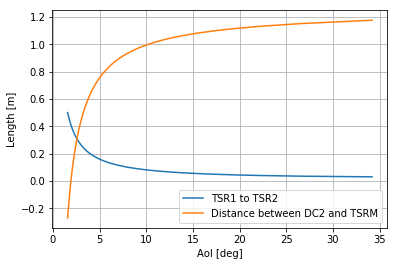

In [27]:
# Safety margin between TSR1 and the optical axis between TSR2 and TSRM.
d = 0.015
# Radius of TSR1
a = 0.0127
# Safety margin between TSR1 and DC1 + safety margin between TSR2 and SRM. Quickly estimated values. 
b = 0.025 + 0.025
# Propagation through crystal
c = 1.8*0.01
# Distance of DCs from crystal
e = 0.04
# Transmission through SRM
f = 0.06*1.45

# Distance between telescope mirrors
L = np.linspace(0.025,0.5,100)
# 2*Angle of incidence on telescope mirrors
theta = np.arcsin((a+d)/L)*180.0/np.pi
# TSR path length (SRC with arms excluded)
L_DC2_TSRM = L_SRC - (L*(1.0+2.0*np.cos(theta*np.pi/180.0)) + b + c + e + f)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta/2.0, L, label='TSR1 to TSR2')
# ax.plot(theta/2.0, L_tsr, label='TSRC minimum boptical path length')
ax.plot(theta/2.0, L_DC2_TSRM, label='Distance between DC2 and TSRM')

# ax.plot(theta/2.0, L_SRC-L_sr, label='Arm length')

#ax.plot([theta.min()/2.0, theta.max()/2.0],[L_SRC,L_SRC], 'r--', label='SRC length')

ax.grid()
ax.set_xlabel('AoI [deg]')
ax.set_ylabel('Length [m]')
ax.legend()
plt.show(fig)

In [28]:
L_tsr2 = 0.376
# 2*Angle of incidence on telescope mirrors
theta = np.arcsin((a+d)/L_tsr2)*180.0/np.pi
# TSR path length (SRC with arms excluded)
L_tsr1 = L_tsr2*np.cos(theta*np.pi/180.0) + 0.035
L_tsr3 = L_tsr2*np.cos(theta*np.pi/180.0) + 0.01
L_DC2_TSRM = L_SRC - (L_tsr2*(1.0+2.0*np.cos(theta*np.pi/180.0)) + b + 1.8*0.01 + 0.04 + 0.06*1.45)
L_tsr2_crys = L_tsr3 + 2e-2 #2 cm is the distance from dichroic to crystal
L_Crys_TSRM = L_DC2_TSRM + 2e-2 #2 cm is the distance from dichroic to crystal

print('Angle of incidence: {} deg'.format(theta/2.0))
print('L_DC2_TSRM: {} m'.format(L_DC2_TSRM))
print('L_tsr1: {} m'.format(L_tsr1))
print('L_tsr3: {} m'.format(L_tsr3))
print('TSR2 to crystal: {} m'.format(L_tsr2_crys))
print('Crystal to TSR: {} m'.format(L_Crys_TSRM))


Angle of incidence: 2.11240986058625 deg
L_DC2_TSRM: 0.10168267550670684 m
L_tsr1: 0.4099782793709523 m
L_tsr3: 0.38497827937095236 m
TSR2 to crystal: 0.4049782793709524 m
Crystal to TSR: 0.12168267550670685 m


## Maximum possible length between TSR2 and crystal


In [34]:
from pykat.optics import ABCD as a

w0 = 30e-6
q0 = BeamParam(w0=w0, z=0, nr=kat.sCRYS.n.value)
S0 = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value/2.0)
S1 = a.mirror_trans(kat.sCRYS.n.value, 1, np.inf)
S3 = a.space(1,0.42)

Ssum1 = S3 * S1 * S0

q2 = a.apply(Ssum1, q0, 1.8, 1.0)

q2.w

0.004772997764312543

In [46]:
w0 = 30e-6
q0 = BeamParam(w0=w0, z=0, nr=kat.sCRYS.n.value)
S0 = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value/2.0)
S1 = a.mirror_trans(kat.sCRYS.n.value, 1, np.inf)
S3 = a.space(1, 0.10)

Ssum1 = S3 * S1 * S0

q2 = a.apply(Ssum1, q0, 1.8, 1.0)

q2.Rc

array(0.10284648)

In [37]:
q2.Rc

array(0.12283529)

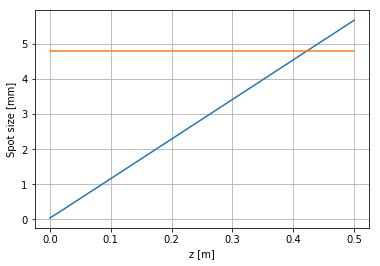

In [30]:
from pykat.optics import ABCD as a

w0 = 30e-6
q0 = BeamParam(w0=w0, z=0, nr=kat.sCRYS.n.value)
S0 = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value/2.0)
S1 = a.mirror_trans(kat.sCRYS.n.value, 1, np.inf)
# S3 = a.space(1,0.4)

Ssum1 = S1 * S0

q2 = a.apply(Ssum1, q0, 1.8, 1.0)


zs = np.linspace(0,0.5,50)
w = np.zeros(len(zs))
for k,z in enumerate(zs):
    w[k] = (q2+z).w
  
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(zs, w*1e3)
ax.plot([zs.min(), zs.max()], [4.8,4.8] )
ax.grid()
ax.set_xlabel('z [m]')
ax.set_ylabel('Spot size [mm]')
plt.show(fig)